In [204]:
import c2qa
import numpy as np
from qiskit import ClassicalRegister, visualization, AncillaRegister
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from math import pi

# Bosonic Error Correction



/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/c2qa/kraus.py:185: UserWarning: PhotonLossNoisePass ignores instructions without duration, you may need to schedule circuit in advance.
  warnings.warn(


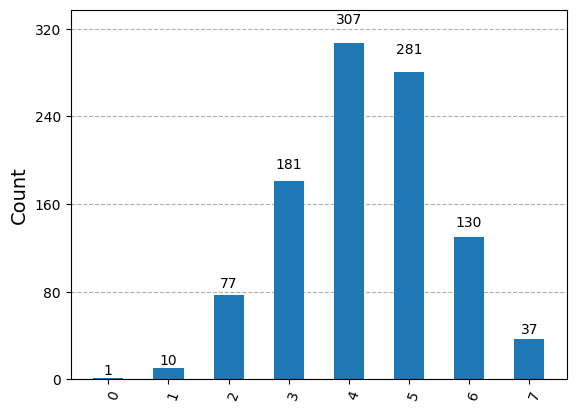

In [259]:
num_qumodes = 1
num_qubits_per_qumode = 3

photon_loss_rate = 0.5 # loss rate in units of 1/ms
circuit_delay = 1 # large enough for on average 2 photons to be lost
time_unit = "ms"

qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
circuit = c2qa.CVCircuit(qmr, cr)

# to illustrate photon loss, initialize the qumode in Fock state |7>
circuit.cv_initialize(7, qmr[0])

# apply a delay to illustrate the effect of photon loss
circuit.cv_delay(duration=circuit_delay, unit=time_unit, qumode=qmr[0])

noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit=time_unit)

circuit.cv_measure(qmr[0], cr)

# circuit.draw('mpl')

counts = c2qa.util.simulate(circuit, noise_passes=noise_pass)[2] # Returns a tuple of state, result, fock_counts

visualization.plot_histogram(counts)

### bla

In [260]:
# Create new circuit with 1 qumode, 1 ancilla qubit, and 1 classical register for ancilla readout.
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
anc = AncillaRegister(1)
cr = ClassicalRegister(1)
circ = c2qa.CVCircuit(qmr, anc, cr)

circ.initialize([1, 0], anc[0]) # Initialize ancilla qubit in |0> (even) state

# Initialize qumode in either odd parity or even parity Fock state
# circ.cv_initialize(2, qmr) # |2> (even) Fock state
circ.cv_initialize(3, qmr) # |3> (odd) Fock state

circ.h(anc[0])

circ.cv_c_r(pi/2, qmr[0], anc[0])
circ.cv_r(-pi/2, qmr[0])

circ.h(anc[0])
circ.cv_measure(anc, cr)

counts = c2qa.util.simulate(circ)[2]

# Measurement will return 0 for even parity and 1 for odd parity
print(counts)

{'1': 1024}


/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### bla

In [234]:
empty = np.zeros((2**num_qubits_per_qumode, 2**num_qubits_per_qumode))

# map logical 1's photon loss state |1> back to logical 1. (i.e. |2><1|, where fock_input = <1|, and fock_output = |2>)
u_odd = c2qa.util.fockmap(matrix=empty, fock_input=[1], fock_output=[2]) 

# map logical 0's photon loss state |3> to logical 0 ((|0> + |4>)/sqrt(2))
u_odd = c2qa.util.fockmap(u_odd, fock_input=[3, 3], fock_output=[0, 4], amplitude=[1/np.sqrt(2), 1/np.sqrt(2)]) 

# satisfy unitary condition
u_odd = c2qa.util.fockmap(u_odd, [5, 6, 7], [5, 6, 7])
u_odd = c2qa.util.fockmap(u_odd, [2, 0], [3, 1]) 
u_odd = c2qa.util.fockmap(u_odd, [4, 4], [0, 4], 1/np.sqrt(2) * np.array([1, -1]))

assert(is_unitary_matrix(u_odd))

def u_even(kt):
    # map logical 1's error back to logical 1
    u_even = c2qa.util.fockmap(empty, 2, 2) 

    # map logical 0's error state to logical 0
    u_even = c2qa.util.fockmap(u_even, [0, 0, 4, 4], [0, 4, 0, 4], 1/np.sqrt(1 + kt**2) * np.array([1, kt, -kt, 1])) 

    # satisfy unitary condition
    u_even = c2qa.util.fockmap(u_even, [1, 3, 5, 6, 7], [1, 3, 5, 6, 7]) 

    assert(is_unitary_matrix(u_even))
    return u_even

### bla

In [235]:
# Initialize new circuit 
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
circ = c2qa.CVCircuit(qmr, cr)

# Initialize qumode in |1_L> error state
circ.cv_initialize([0, 1], qmr) # (0 * |0> + 1 * |1>) = |1>

# Append the u_odd matrix to circuit and measure
circ.cv_gate_from_matrix(u_odd, qmr[0])
circ.cv_measure(qmr[0], cr)

counts = c2qa.util.simulate(circ)[2]

# We measure |2> Fock state, demonstrating recovery of the logical 1 state
print(counts)

{'2': 1024}


# -this-

/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/c2qa/kraus.py:185: UserWarning: PhotonLossNoisePass ignores instructions without duration, you may need to schedule circuit in advance.
  warnings.warn(
/Users/benjamin/Code Projects/HvA/exploring-bosonic-qiskit-qec/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


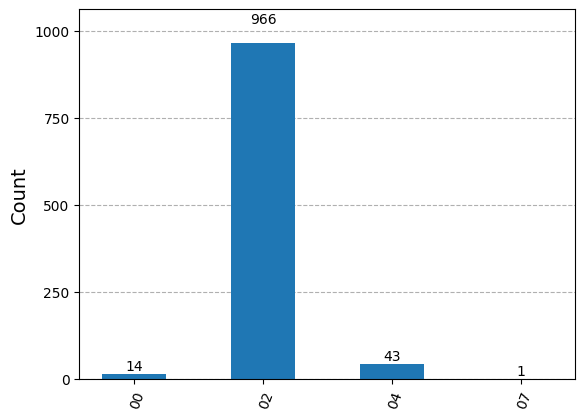

In [258]:
num_qumodes = 1
num_qubits_per_qumode = 3

photon_loss_rate = 0.5 # loss rate in units of 1/ms
circuit_delay = 0.5
time_unit = "ms"

# create circuit
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
anc = AncillaRegister(1)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode + 1)
circuit = c2qa.CVCircuit(qmr, anc, cr)


def do_error_correction(circuit):
    # photon parity measurement
    circuit.h(anc[0])
    circuit.cv_c_r(pi/2, qmr[0], anc[0])
    
    circuit.cv_r(-pi/2, qmr[0])
    
    circuit.h(anc[0])
    circuit.measure(anc[0], cr[0])
            
    kt_dur = circuit_delay # time since previous error correction
    kt = photon_loss_rate * (kt_dur + 3)
            
    with circuit.if_test((cr[0], 1), label='Recovery op') as else_:
        circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0.1, unit="ns")
        circuit.reset(anc[0])
    with else_:
        circuit.cv_gate_from_matrix(u_even(kt), qmr[0], duration=0.1, unit="ns")
    

# initialize ancilla qubit in even |0> or odd |1> state
circuit.initialize(0, anc[0]) 
# initialize qumode in Fock state even or odd
circuit.cv_initialize(2, qmr[0])

# apply a delay to illustrate the effect of photon loss
circuit.cv_delay(duration=circuit_delay, unit=time_unit, qumode=qmr[0])

# apply error correction
do_error_correction(circuit)

noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit=time_unit)

# to see the loss and correction, add measurements and count up the results
circuit.cv_measure(qmr[0], cr)

# circuit.draw('mpl')

counts = c2qa.util.simulate(circuit, noise_passes=noise_pass)[2] # Returns a tuple of state, result, fock_counts

visualization.plot_histogram(counts)